In [1]:
sys.path.insert(0, '../python')
import cool_tigress as ct

class PDR_H2_only(object):
    
    def __init__(self, xmin=0.0, xmax=50.0, dx=1.0, 
                 nH=1e2, G0=1e4, xi_H=2.0e-16, R_gr=3.0e-17, b5=3.0,
                 kappad=418.0,
                 solve=True):
        
        self.xmin = xmin
        self.xmax = xmax
        self.dx = dx
        self.dx_cm = (dx*au.pc).to('cm').value
        self.Nx = int((xmax - xmin)/dx)
        assert (xmax-xmin)/self.Nx == dx
        
        self.xf = np.linspace(xmin, xmax, self.Nx + 1)
        self.xc = (self.xf + 0.5*dx)[:-1]
        
        self.G0 = G0
        self.b5 = b5
        self.xi_H = xi_H
        self.R_gr = R_gr
        self.kappad = kappad
        muH = 1.4271*ac.m_p
        self.sigmad = (kappad*au.cm**2/au.g*muH).to('cm**2').value

        # H2 photodissociation rate scaled by ISRF (G0=1)
        self.zeta0 = 5.7e-11
        
        self.set_array(nH, G0)
        if solve:
            self.solve()

    def set_array(self, nH, G0):
        
        Nx = self.Nx
        self.nHc = np.repeat(nH, Nx)
        self.nH2c = np.empty((Nx,))
        self.NHf = np.zeros((Nx + 1,))
        self.NH2f = np.zeros((Nx + 1,))
        self.dNH2 = np.zeros((Nx,))
        self.fH2c = np.empty((Nx,))
        
        # self.G0c = np.empty((Nx,))
        self.G0f = np.empty((Nx + 1,))
        self.G0f[0] = G0
        
    def solve(self):
        for i in range(self.Nx):
            #print(i, NH2f[i])
            self.G0f[i + 1] = self.G0f[i]*np.exp(-self.nHc[i]*self.dx_cm*self.sigmad)
            zeta = self.zeta0*self.G0f[i + 1]*self.f_shdH2(self.NH2f[i], self.b5)
            #zeta = self.zeta0*(0.5*(self.G0f[i] + self.G0f[i + 1]))*self.f_shdH2(self.NH2f[i], self.b5)
            self.fH2c[i] = self.calc_fH2_equil(self.nHc[i], self.xi_H, self.R_gr, zeta=zeta)
            self.nH2c[i] = self.fH2c[i]*self.nHc[i]
            
            self.NHf[i + 1] = self.NHf[i] + self.nHc[i]*self.dx_cm
            self.NH2f[i + 1] = self.NH2f[i] + self.nH2c[i]*self.dx_cm
            self.dNH2[i] = self.nH2c[i]*self.dx_cm

    @staticmethod
    def calc_fH2_equil(nH, xi_H = 2.0e-16, R_gr = 3.0e-17, zeta=5.7e-11):
        a = 2.31*xi_H
        b = -2.0*R_gr*nH - 4.95*xi_H - zeta
        c = nH*R_gr
        return (-b - np.sqrt(b**2 - 4.0*a*c))/(2.0*a)

    @staticmethod
    def f_shdH2(NH2, b5=3.0):
        x = NH2/5.0e14
        return 0.965/(1.0 + x/b5)**2 + \
                  0.035/(1.0 + x)**0.5*np.exp(-8.5e-4*(1.0 + x)**0.5)


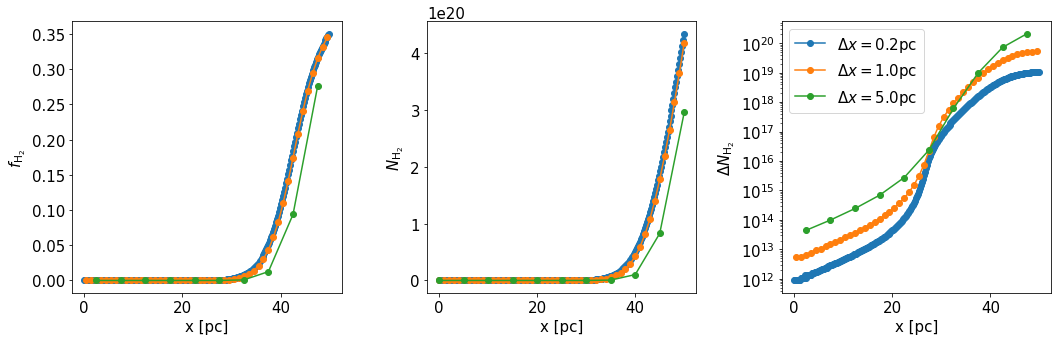

In [2]:
mpl.rcParams['font.size'] = 15
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

nH = 5e1
G0 = 1e3
xmax = 50.0
p1 = PDR_H2_only(dx=0.2, G0=G0, nH=nH, xmax=xmax)
p2 = PDR_H2_only(dx=1.0, G0=G0, nH=nH, xmax=xmax)
p3 = PDR_H2_only(dx=5.0, G0=G0, nH=nH, xmax=xmax)
lines = []
dx = [r'$\Delta x=$' + str(dx) + 'pc' for dx in [p1.dx, p2.dx, p3.dx]]
for p in (p1, p2, p3):
    plt.sca(axes[0])
    l, = plt.plot(p.xc, p.fH2c , '-o')
    plt.sca(axes[1])
    plt.plot(p.xf, p.NH2f , '-o')
    plt.sca(axes[2])
    plt.plot(p.xc, p.dNH2 , '-o')

    lines.append(l)

for ax in axes:
    ax.set_xlabel('x [pc]')
axes[0].set_ylabel(r'$f_{\rm H_2}$')
axes[1].set_ylabel(r'$N_{\rm H_2}$')
axes[2].set_ylabel(r'$\Delta N_{\rm H_2}$')
axes[2].set_yscale('log')

plt.legend(lines, dx)
plt.tight_layout()